In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Рассмотрим простой датасет BeetleFly (https://timeseriesclassification.com/description.php?Dataset=BeetleFly)

In [10]:
### В данном задании нам при помощи KNN и DTW нужно будет построить классификатор, который будет отличать контуры
### жуков от контуров мух (бинарная классификация). Каждое изображение уже преобразовано во временной ряд длины 512.

In [2]:
with open('../data/beetle_fly/BeetleFly_TRAIN.ts') as f:
    data = f.read().split('\n')[11:-1]

In [3]:
X_train = []
y_train = []

In [4]:
for row in data:
    ts, label = row.split(':') 
    ts = np.array(list(map(float, ts.split(','))))
    X_train.append(ts)
    y_train.append(label)

In [5]:
### всего двадцать обьектов обучающей выборки, из них 10 жуков и 10 мух
print(y_train)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']


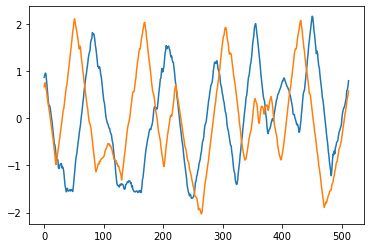

In [6]:
# жуки
plt.plot(X_train[3])
plt.plot(X_train[5])

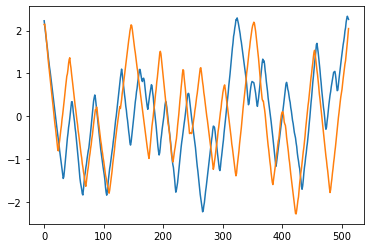

In [7]:
# мухи
plt.plot(X_train[14])
plt.plot(X_train[17])

#### Задание: написать реализацию KNN(k=1) используя в качестве меры Dynamic Time Wraping с прошлого семинара.

In [17]:
from typing import Tuple, List
def make_distance_matrix(ts_1: np.array, ts_2: np.array) -> np.array:
    """
    Должна вернуть матрицу размерности (len(ts_1), len(ts_2)),
    в которой каждый элемент (i, j) равен евклидовому расстоянию от 
    точки ts_1[i] до точки ts_2[j]
    """
    # ваш код здесь
    d_matrix=[]
    for _ts_2 in ts_2:
        d_matrix.append(abs(ts_1-_ts_2))
    return np.array(d_matrix)

In [18]:
def get_ancestors(i: int, j: int, matrix: np.array) -> Tuple[int]:
    up = matrix[i-1][j] if i else np.inf
    left = matrix[i][j-1] if j else np.inf
    diag = matrix[i-1][j-1] if j and i else np.inf
    up = matrix[0][0] if i==0 and j==0 else up #значение 0,0 берем из матрицы 0,0
    # ваш код здесь
    return up, left, diag

In [19]:
def make_difference_matrix(d_matrix):
    """
    Должна возвращать матрицу D, в которой каждый элемент высчитывается как 
    D(i, j) = d_{ij} + min(D_{i-1, j}, D_{i-1, j-1}, D_{i, j-1})
    """
    # <ваш код здесь>
    D = np.zeros(d_matrix.shape)
    for i in range(d_matrix.shape[0]):
        for j in range(d_matrix.shape[1]):
            D[i][j]=d_matrix[i][j]+min(get_ancestors(i, j, D))
    return D

In [20]:
def find_path_and_dtw(ts_1: np.array, ts_2: np.array, D: np.array, d_matrix: np.array) -> Tuple[List[Tuple], float]:
    """
    Функция должна возвращать путь от точки (len(ts_1), len(ts_2)) до точки (0, 0)
    в виде списка из координат (i, j), а также значение dtw. 
    """
    path = []
    dtw = 0
    path_dict={ 0:'up', 1:'left', 2:'diag'}
    i = len(ts_1)-1
    j = len(ts_2)-1

    path.append((i, j))
    
    while i or j:
        get_anc = get_ancestors(i, j, D)
        route = path_dict[np.where(get_anc == min(get_anc))[0][0]]
        if route == 'up': i-=1
        if route == 'left': j-=1
        if route == 'diag': i-=1; j-=1
        path.append((i, j))

    # <ваш код здесь>
   
    path = path[::-1]
    
    for i, j in path:
        dtw += d_matrix[i, j] 
    return path, dtw

In [21]:
with open('../data/beetle_fly/BeetleFly_TEST.ts') as f:
    data = f.read().split('\n')[11:-1]

In [22]:
X_test = []
y_test = []

In [23]:
for row in data:
    ts, label = row.split(':') 
    ts = np.array(list(map(float, ts.split(','))))
    X_test.append(ts)
    y_test.append(label)

In [98]:
def my_calculate_dtw(ts_1, ts_2):
    d_matrix = make_distance_matrix(ts_1, ts_2)
    D = make_difference_matrix(d_matrix)
    dtw = find_path_and_dtw(ts_1, ts_2, D, d_matrix)
    return dtw


In [107]:
labels=[]
for test in X_test:
    dtws = []
    for i in range (len(X_train)):
        ts_1, ts_2=test, X_train[i]
        dtws.append(my_calculate_dtw(ts_1, ts_2)[1])
    dtws=np.array(dtws)
    dtws=np.where(dtws==0,np.inf,dtws)
    labels.append(y_test[np.where(dtws == min(dtws))[0][0]])

In [108]:
#accuracity
1-abs(np.array(labels).astype(int)-np.array(y_test).astype(int)).sum()/len(y_test)

0.7

In [76]:
import fastdtw

#### fastdtw реализация

In [115]:
def get_label(ts, X_train, y_train):
    dtw_values = np.array([fastdtw.dtw(ts, ts_reference)[0] for ts_reference in X_train])
    np.where(dtw_values == min(dtw_values))
    idx = np.where(dtw_values == min(dtw_values))[0][0]
    label = y_train[idx]
    return label

In [116]:
labels_fast=[]
for i in range(0, 20):
    labels_fast.append(get_label(X_test[i], X_train, y_train))

In [117]:
#accuracity
1-abs(np.array(labels_fast).astype(int)-np.array(y_test).astype(int)).sum()/len(y_test)

0.7